In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm import tqdm

In [3]:
class BlackJack:
    vals=['A',2,3,4,5,6,7,8,9,10,10,10,10]


    def reset(self):
        self.dealer_shown=np.random.choice(self.vals)
        self.dealer_hidden=np.random.choice(self.vals)

        self.dealer_non_ace_cards=[]
        self.dealer_aces=0

        for c in (self.dealer_shown, self.dealer_hidden):
            if c=='A':
                self.dealer_aces+=1
            else:
                self.dealer_non_ace_cards.append(int(c))

        self.player_non_ace_cards=[]
        self.aces=0

        self.game_state=1 # game not truncated

        while self.score<12:
            self.hit()

        if self.score==21:
            self.game_state=0
        
        r=self._result if self.game_state==0 else 0

        return self.state,r,not bool(self.game_state)


    def step(self,action):
        # action 1 is hit and 0 is stick
        assert action in (0,1), "Action {} not allowed".format(action)
        if action==1:
            self.hit()
            r=self._result if self.game_state==0 else 0
            return self.state, r, not bool(self.game_state) 
        else:
            self.stick()
            return self.state, self._result, not bool(self.game_state) 
        


    @property
    def score(self):
        t=sum(self.player_non_ace_cards)
        a=self.aces
        if a:
            if 21-t>11:
                t+=11
                a-=1
        if a:
            t+=a
        return t

    @property
    def state(self):
        t=sum(self.player_non_ace_cards)
        usable=21-t>11 and self.aces
        return (self.score,bool(usable),self.dealer_shown)

    @property
    def _dealer_score(self):
        t=sum(self.dealer_non_ace_cards)
        a=self.dealer_aces
        if a:
            if 21-t>11:
                t+=11
                a-=1
        if a:
            t+=a
        return t

    def hit(self):
        if self.game_state==0:
            raise Exception('Game Ended')
        v=np.random.choice(self.vals)
        if v=='A':
            self.aces+=1
        else:
            self.player_non_ace_cards.append(int(v))
        if self.score>21:
            self.game_state=0
        

    
    def _dealer_hit(self):
        v=np.random.choice(self.vals)
        if v=='A':
            self.dealer_aces+=1
        else:
            self.dealer_non_ace_cards.append(int(v))

        if self._dealer_score>21:
            self.game_state=0
        return self.game_state,self._dealer_score
    

    def stick(self):
        if self.game_state==0:
            raise Exception('Game Ended')
        while self._dealer_score<17:
            self._dealer_hit()
        self.game_state=0

    @property
    def _result(self):
        assert self.game_state==0, "_result Called Before Game Ended"
        if self.score>21:
            return -1
        elif self._dealer_score>21:
            return 1
        elif self.score>self._dealer_score:
            return 1
        elif self.score<self._dealer_score:
            return -1
        else:
            return 0

   
    def check_natural(self):
        if self.score==21:
            if self._dealer_score==21:
                return 0
            else:
                return 1

In [4]:
g=BlackJack()

In [8]:
g.reset()

((15, False, '10'), 0, False)

In [9]:
g.step(1)

((23, False, '10'), -1, True)

In [10]:
g.reset()

((17, False, '10'), 0, False)

In [11]:
g.step(0)

((17, False, '10'), 0, True)

In [12]:
g._dealer_score

17

In [13]:
class Value:
    def __init__(self):
        self.vals=np.zeros((10,2,10))
        self.ns=np.zeros((10,2,10))

    def put(self,score,usable,dealer_showing,v):
        x=score-12
        y=0 if dealer_showing=='A' else int(dealer_showing)-1
        if x>=10 or y>=10:
            print(score,x,dealer_showing,y)
        self.ns[x][int(usable)][y]+=1.0
        self.vals[x][int(usable)][y]+= (v-self.vals[x][int(usable)][y])/self.ns[x][int(usable)][y]

    def get(self,score,usable,dealer_showing):
        x=score-12
        y=0 if dealer_showing=='A' else int(dealer_showing)-1
        return self.vals[x][int(usable)][y]


In [14]:
vs=Value()
for i in tqdm(range(20000)):
    states=[]
    
    state,reward,done = g.reset()
    states.append(state)
    while not done and state[0]<20:
        state,reward,done=g.step(1)
        states.append(state)
    if not done:
        state,reward,done=g.step(0)
        states.append(state)
    
    for s in reversed(states):
        if s[0] <=21:
            vs.put(s[0],s[1],s[2],reward)
    

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [00:03<00:00, 6469.78it/s]


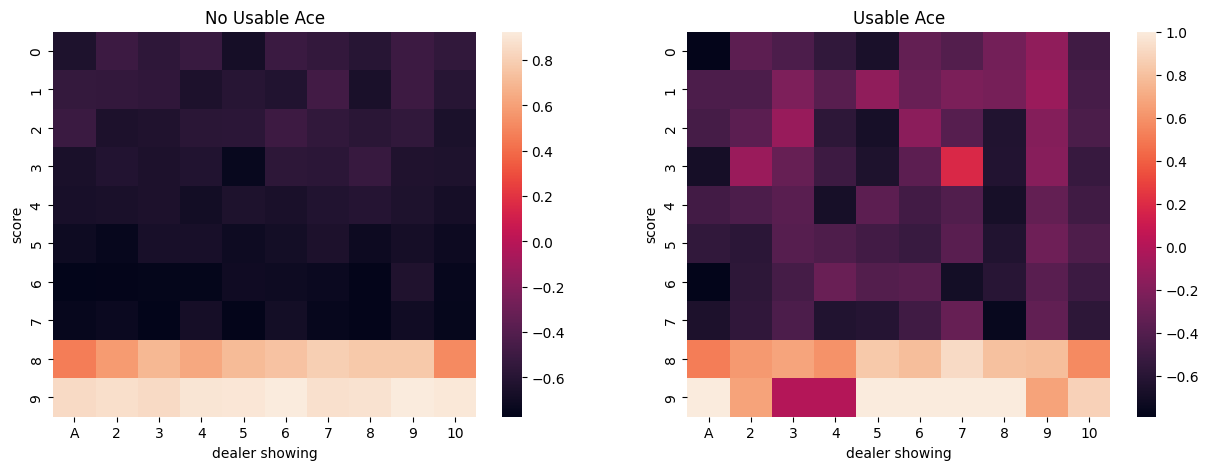

In [15]:
_,axs=plt.subplots(1,2,figsize=(15,5))
sns.heatmap(vs.vals[:,0,:],ax=axs[0]),
sns.heatmap(vs.vals[:,1,:],ax=axs[1])

axs[0].set_xlabel('dealer showing')
axs[1].set_xlabel('dealer showing')

axs[0].set_ylabel('score')
axs[1].set_ylabel('score')

axs[0].set_title('No Usable Ace')
axs[1].set_title('Usable Ace')

axs[0].set_xticklabels(['A']+list(map(str,range(2,11))))
axs[1].set_xticklabels(['A']+list(map(str,range(2,11))))
plt.show()

In [ ]:

for i in tqdm(range(20000,500000)):
    states=[]
    
    state,reward,done = g.reset()
    states.append(state)
    while not done and state[0]<20:
        state,reward,done=g.step(1)
        states.append(state)
    if not done:
        state,reward,done=g.step(0)
        states.append(state)
    
    for s in reversed(states):
        if s[0] <=21:
            vs.put(s[0],s[1],s[2],reward)
    

100%|██████████| 480000/480000 [01:17<00:00, 6170.89it/s]


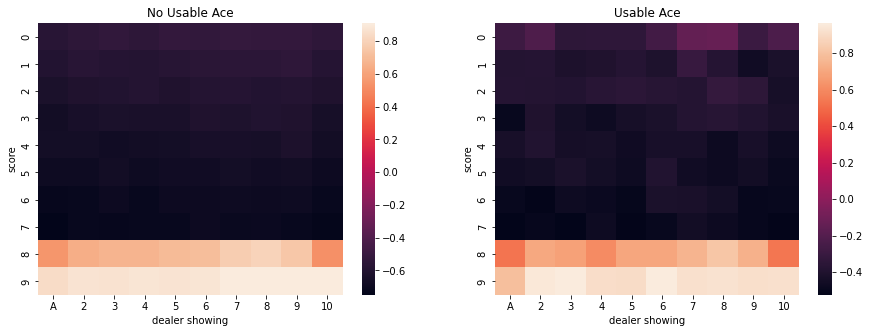

In [ ]:
_,axs=plt.subplots(1,2,figsize=(15,5))
sns.heatmap(vs.vals[:,0,:],ax=axs[0]),
sns.heatmap(vs.vals[:,1,:],ax=axs[1])

axs[0].set_xlabel('dealer showing')
axs[1].set_xlabel('dealer showing')

axs[0].set_ylabel('score')
axs[1].set_ylabel('score')

axs[0].set_title('No Usable Ace')
axs[1].set_title('Usable Ace')

axs[0].set_xticklabels(['A']+list(map(str,range(2,11))))
axs[1].set_xticklabels(['A']+list(map(str,range(2,11))))
plt.show()

In [ ]:
class Q:
    def __init__(self):
        self.vals=np.random.normal(size=(10,2,10,2))
        self.cs=np.zeros((10,2,10,2))
        

    def put(self,score,usable,dealer_showing,action,w,g):
        x=score-12
        y=0 if dealer_showing=='A' else int(dealer_showing)-1
        
        self.cs[x][int(usable)][y][action]+=w
        self.vals[x][int(usable)][y][action]+=w/self.cs[x][int(usable)][y][action]*(g-self.vals[x][int(usable)][y][action])

    def get(self,score,usable,dealer_showing):
        x=score-12
        y=0 if dealer_showing=='A' else int(dealer_showing)-1
        return self.vals[x][int(usable)][y]


In [ ]:
qs=Q()
for i in tqdm(range(2000000)):

    t=0
    states=[]
    actions=[]
    rewards=[]
    
    state,reward,done = g.reset()
    states.append(state)
    rewards.append(reward)

    while not done:
        action=np.random.choice([0,1])
        state,reward,done=g.step(action)
        actions.append(action)

        t+=1
        states.append(state)
        rewards.append(reward)

    G=0
    W=1
    T=t
    for t in range(T-1,-1,-1):
        G+=rewards[t+1]
        s=states[t]
        a=actions[t]
        W=W*2
        qs.put(s[0],s[1],s[2],a,W,G)
        p=np.argmax(qs.get(s[0],s[1],s[2]))
        if a!=p:
            break
        #W=W*2




100%|██████████| 2000000/2000000 [06:13<00:00, 5350.18it/s]


Text(0.5, 1.0, 'Action - No Usable Ace')

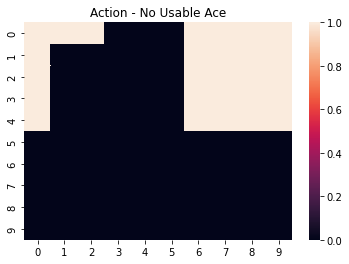

In [ ]:
sns.heatmap(np.argmax(qs.vals[:,0],axis=2))
plt.title('Action - No Usable Ace')

Text(0.5, 1.0, 'Action - Usable Ace')

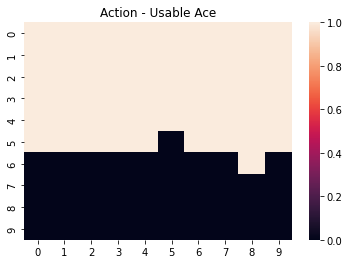

In [ ]:
sns.heatmap(np.argmax(qs.vals[:,1],axis=2))
plt.title('Action - Usable Ace')

Text(0.5, 1.0, 'Value - No Usable Ace')

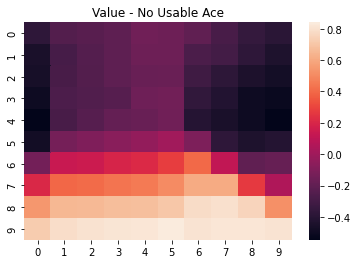

In [ ]:
sns.heatmap(np.max(qs.vals[:,0],axis=2))
plt.title('Value - No Usable Ace')

Text(0.5, 1.0, 'Value - Usable Ace')

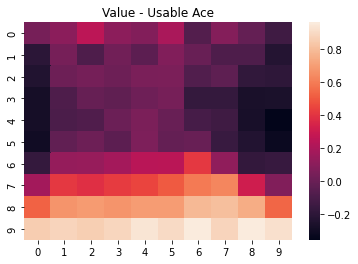

In [ ]:
sns.heatmap(np.max(qs.vals[:,1],axis=2))
plt.title('Value - Usable Ace')